In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
    #    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!mv /content/intern_datasets/yolo/train/labels/*.jpg /content/intern_datasets/yolo/train/images

mv: cannot stat '/content/intern_datasets/yolo/train/labels/*.jpg': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/DS/intern_datasets.zip intern_datasets.zip

In [8]:
!unzip intern_datasets.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: intern_datasets/yolo/train/labels/train_image_4945.txt  
  inflating: intern_datasets/yolo/train/labels/train_image_1183.txt  
  inflating: intern_datasets/yolo/train/labels/train_image_3794.txt  
  inflating: intern_datasets/yolo/train/labels/train_image_3480.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image_2946.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image_3964.txt  
  inflating: intern_datasets/yolo/train/labels/train_image_0189.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image_1297.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image_0837.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image_4489.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image_1815.txt  
  inflating: intern_datasets/yolo/train/labels/train_image_1801.txt  
  inflating: intern_datasets/yolo/train/labels/train_image_0823.jpg  
  inflating: intern_datasets/yolo/train/labels/train_image

# Prepare Data for YOLOv5 Format

**Create directories to hold images and txt files for annotations (train , val ,test)**

In [10]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

**classes**

In [11]:
classes = ['helmet','head','person']

**calculate ancor points and hiegt width of bonding boxes**

In [12]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]


In [13]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = './Dataset/labels/' +  img_jpg_file_name + '.txt'
    print(save_file_name)
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [14]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [15]:
!ls ./Dataset/labels

In [16]:
files = os.listdir('/content/intern_datasets/yolo/train')
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    print(file_xml[0])
    get_xml_data('/content/intern_datasets/yolo/train', file_xml[0])

file name:  images
images


FileNotFoundError: ignored

# split train val test

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/kaggle/input/hard-hat-detection/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( './Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('./Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.jpg', '')        
        img_src_file = imgs_source + '/' + img_name + '.jpg'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = './Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.jpg'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = './Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
copy_data(train_list, '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "train")
copy_data(val_list,   '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "val")
copy_data(test_list,  '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [ ]:
!ls /kaggle/working/Dataset/images

test  train  val


# Get YOLOv5 model

In [17]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10354, done.
remote: Total 10354 (delta 0), reused 0 (delta 0), pack-reused 10354
Receiving objects: 100% (10354/10354), 10.57 MiB | 25.34 MiB/s, done.
Resolving deltas: 100% (7147/7147), done.
/content/yolov5


In [18]:
!ls 

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  tutorial.ipynb
data		 export.py   models	setup.cfg	  utils
detect.py	 hubconf.py  README.md	train.py	  val.py


**create yaml file for configuration**

In [19]:
import yaml

dict_file = {'train':'/content/intern_datasets/yolo/train' ,
            'val': '/content/intern_datasets/yolo/test',
            'nc' : '3',
            'names' : ['head','helmet','person']}

with open('./data/hard_head.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)

# Train Net

In [20]:
pip install -r requirements.txt

     |████████████████████████████████| 596 kB 5.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [22]:
!nvidia-smi

Wed Dec 22 06:33:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    85W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
!python train.py --img 416 --adam --batch 32 --epochs 30 --data data/hard_head.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/hard_head.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=True, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-155-gdc54ed5 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, tr

# Detect (predict)

In [25]:
!pwd

/content/yolov5


In [26]:
!cp /content/drive/MyDrive/DS/評価用.zip 評価用.zip

In [27]:
!unzip 評価用.zip

Archive:  評価用.zip
   creating: test/
  inflating: test/IMG_7960.jpg       
  inflating: test/IMG_7948.jpg       
  inflating: test/IMG_7949.jpg       
  inflating: test/IMG_7961.jpg       
  inflating: test/IMG_7963.jpg       
  inflating: test/IMG_7962.jpg       
  inflating: test/IMG_7972.jpg       
  inflating: test/IMG_7966.jpg       
  inflating: test/IMG_7967.jpg       
  inflating: test/IMG_7973.jpg       
  inflating: test/IMG_7959.jpg       
  inflating: test/IMG_7965.jpg       
  inflating: test/IMG_7971.jpg       
  inflating: test/IMG_7970.jpg       
  inflating: test/IMG_7964.jpg       
  inflating: test/IMG_7958.jpg       
  inflating: test/IMG_7955.jpg       
  inflating: test/IMG_7969.jpg       
  inflating: test/IMG_7968.jpg       
  inflating: test/IMG_7954.jpg       
  inflating: test/IMG_7956.jpg       
  inflating: test/IMG_7957.jpg       
  inflating: test/IMG_7953.jpg       
  inflating: test/IMG_7947.jpg       
  inflating: test/IMG_7952.jpg       
  inflating: 

In [28]:
!ls

CONTRIBUTING.md  export.py   __pycache__       setup.cfg       utils
data		 hubconf.py  README.md	       test	       val.py
detect.py	 LICENSE     requirements.txt  train.py        yolov5s.pt
Dockerfile	 models      runs	       tutorial.ipynb  評価用.zip


In [35]:
!mkdir test_resize

In [36]:
from PIL import Image

# path to test data
img_path = Path("./test")

imgs = list(img_path.iterdir())
for i in imgs:
  img = Image.open(i)
  img_resize = img.resize((416, 416))
  img_resize.save(Path('test_resize') / i.name)

In [37]:
#!python detect.py --source /kaggle/working/Dataset/images/test --img-size 416 --conf 0.4 --weights weights.pt 
#!python detect.py --source /kaggle/working/Dataset/images/test  --weights yolov5s.pt --conf 0.25
!python detect.py --source ./test_resize/ --img-size 416 --conf 0.4 --weights runs/train/exp2/weights/best.pt

detect: weights=['runs/train/exp2/weights/best.pt'], source=./test_resize/, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-155-gdc54ed5 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/27 /content/yolov5/test_resize/IMG_7947.jpg: 416x416 3 helmets, Done. (0.028s)
image 2/27 /content/yolov5/test_resize/IMG_7948.jpg: 416x416 2 helmets, Done. (0.027s)
image 3/27 /content/yolov5/test_resize/IMG_7949.jpg: 416x416 2 helmets, Done. (0.028s)
image 4/27 /content/yolov5/test_resize/IMG_7950.jpg: 416x416 5 helmets, Done. (0.028s)
image 5/27 /content/yolov5/test_resize/IMG_7951.jpg: 4

In [40]:
# display detected images
from IPython.display import Image

<function matplotlib.pyplot.show>

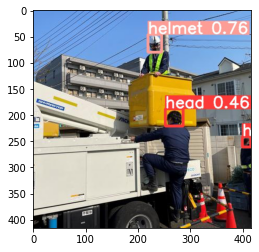

In [53]:
from glob import glob
import matplotlib.pyplot as plt
testfiles = glob('runs/detect/exp3/*')

img = plt.imread(testfiles[14]) 
plt.imshow(img)    
plt.show

In [46]:
!pwd

/content/yolov5


In [47]:
!cd ..

In [48]:
!pwd

/content/yolov5


In [51]:
!zip -r /content/down /content/yolov5

  adding: content/yolov5/ (stored 0%)
  adding: content/yolov5/models/ (stored 0%)
  adding: content/yolov5/models/yolov5m.yaml (deflated 60%)
  adding: content/yolov5/models/yolov5n.yaml (deflated 60%)
  adding: content/yolov5/models/__init__.py (stored 0%)
  adding: content/yolov5/models/yolov5x.yaml (deflated 60%)
  adding: content/yolov5/models/yolov5l.yaml (deflated 61%)
  adding: content/yolov5/models/yolov5s.yaml (deflated 60%)
  adding: content/yolov5/models/tf.py (deflated 70%)
  adding: content/yolov5/models/common.py (deflated 71%)
  adding: content/yolov5/models/experimental.py (deflated 61%)
  adding: content/yolov5/models/hub/ (stored 0%)
  adding: content/yolov5/models/hub/yolov5-fpn.yaml (deflated 57%)
  adding: content/yolov5/models/hub/yolov5-p6.yaml (deflated 66%)
  adding: content/yolov5/models/hub/yolov3.yaml (deflated 63%)
  adding: content/yolov5/models/hub/yolov5s6.yaml (deflated 65%)
  adding: content/yolov5/models/hub/yolov5-bifpn.yaml (deflated 60%)
  adding:

In [ ]:
from google.colab import files
files.download('file_name')

In [52]:
!cp -r '/content/yolov5' /content/drive/MyDrive/DS/